In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
from scipy.optimize import fmin, minimize

In [2]:
rows = 100
df = pd.read_csv('./Data/Highway_V1.csv', nrows = rows)
print(df.head())
print(df.shape)
N = df.shape[0]



def write_csv(data_row):
    path  = "kernelABC_NO_vehsPerHour.csv"
    with open(path,'a+') as f:
        csv_write = csv.writer(f)
        csv_write.writerow(data_row)

write_csv(["maxSpeed","minGap","accel","decel", "θ distance", "Ɣ**2", "ƛ", "Σw"])

    maxSpeed    minGap     accel     decel       y_flow    y_speed   distance
0  25.000000  2.500000  2.600000  4.500000  1853.935338  12.747027   0.000000
1  21.474007  1.338518  4.533689  5.519486  1783.772727  21.129545  70.661578
2  15.154605  4.173119  7.197450  0.605079  1778.685455  14.513182  75.270607
3  24.810924  7.453838  9.010386  2.086053  1790.871818  24.017045  64.062632
4  40.728587  0.635601  6.904782  6.675052  1810.636364  38.569545  50.414320
(100, 7)


In [3]:
'''
****************
Kernel Herding Class
****************

input: 
    - lambda: float
    - theta : 2D array of parameters
    - y     : 2D array of measures   (sensor data)
    - y_star: 1D array of measures   (ground truth)
    
output:
    - theta_hat: 1D array of parameters (predicted)
    - w        : calculated weight vector
'''

class kernel_Herding:
    def __init__(self, lambda_, theta, y, y_star,gamma, niter):
        self.lambda_ = lambda_
        self.theta = theta
        self.npara = len(self.theta[0])
        self.y = y
        self.y_star = y_star
        self.kernel_mean = self.calc_kernel_mean
        self.h = self.calc_kernel_mean
        
        self.N = len(y)
        self.GaMa = gamma
        self.G = self.calc_G()
        self.I = np.identity(self.N)
        self.k_vec = self.calc_k_vector()
        
        self.niter = niter
    
    def get_N(self):
        return self.N
    
    def calc_k(self, yi, yj):
        #__yi = yi.reshape(yi.shape[0],1)
        norm_distance = np.linalg.norm(yi - yj) ** 2
        #gramm_value = (yi-yj).T @ (yi-yj)
        #__temp = (__yi - __yj).T @ (__yi - __yj)
        
        # checked with in multiple way of computation
        #assert abs(norm_distance - __temp[0][0]) < 1, f'{norm_distance} {__temp}'
        #assert abs(gramm_value - __temp[0][0]) < 1, f'{gramm_matrix} {__temp}'
        #assert abs(norm_distance - gramm_value) < 1
        
        k = np.exp( - 1 * norm_distance / self.GaMa )
#         assert k > 0.0, f'k is non-positive value {k}, norm_distance {norm_distance}, GaMa {self.GaMa}'
        return k
        
    def calc_Gama(self):
        # check that input of Gamma computation is from y_simulator 
        GaMa_mat = []
        for i in range(self.N):
            GaMa_row = []
            for j in range(self.N):
                if j != i:
                    GaMa_row.append( (self.y[i] - self.y[j]).T @ (self.y[i] - self.y[j]) )
            GaMa_mat.append(GaMa_row)
        GaMa_mat = np.array(GaMa_mat)
        __Gama_original = np.median(GaMa_mat)
        
        # double check
        distance_matrix = []
        for i in range(self.N):
            one_row = []
            for j in range(self.N):
                if j != i:
                    __dis = np.linalg.norm(self.y[i] - self.y[j]) ** 2
                    one_row.append(__dis)
            else:
                distance_matrix.append(one_row)
        
        # end for loop
        Gama = np.median(distance_matrix)
        
        assert abs(Gama - __Gama_original) < 1
        print("Original Gama: ", __Gama_original)
        return __Gama_original

        Y_Ystar_norm2 = df.loc[:,'distance']**2
        median_Y_Ystar_norm2 = np.median(Y_Ystar_norm2)
        print("The median of the norm^2 distance: ", median_Y_Ystar_norm2)
#         return median_Y_Ystar_norm2
        
        Y_Ystar_norm2 = df.loc[:,'distance']**2
        mean_Y_Ystar_norm2 = np.mean(Y_Ystar_norm2)
        print("The mean of the norm^2 distance: ", mean_Y_Ystar_norm2)

#         return mean_Y_Ystar_norm2

    def calc_G(self):
        G = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                G[i][j] = self.calc_k(self.y[i], self.y[j])
        return G
    
    def calc_k_vector(self):
        k_vec = []  # (99,1)
        for i in range(self.N):
            # checked input of k is from y_simulator and y_star
            out_kernel = self.calc_k( self.y[i], self.y_star )
            assert isinstance(out_kernel, float)
            k_vec.append( out_kernel )
        # k_vec = np.array(k_vec).reshape(-1,1) # list to array
#         print("k_vec shape: ", k_vec.shape)   # size - 99x1
        return k_vec
    
    def calc_w(self):
        assert self.G.shape == (self.N, self.N)
        assert self.I.shape == (self.N, self.N) 
        mat_before_inverse = self.G + self.N * self.lambda_ * self.I
        assert mat_before_inverse.shape == (self.N, self.N)
        w = np.linalg.inv(mat_before_inverse) @ self.k_vec
#         print("w shape: ", w.shape) # size - 99x1
        assert len(w) == self.N
        #print("weight sum: ", np.sum(w))
        return w
    
    def calc_theta_hat(self):
        self.w = self.calc_w()
        
        # double check to compute w
        check_params = []
        for one_param in self.theta.T:
            assert len(one_param) == self.N
            theta_hat_param = sum([self.w[index] * theta_value for index, theta_value in enumerate(one_param)])
            check_params.append(theta_hat_param)
        
        theta_hat = self.w.T @ self.theta
        return theta_hat
    
    def calc_kernel_mean(self, x):
        return sum(self.w*self.calc_k(x, self.theta.flatten()))
    
    def sample_theta(self):
        #bnds = [(0, 20)]*(self.N * self.npara)
        self.theta = minimize(lambda x : -self.h(x), np.ones((self.N, self.npara)).flatten()).x #bounds = bnds
        h = self.h
        self.h = lambda y : h(y) + self.kernel_mean(y) - (lambda x:self.calc_k(x, self.theta.flatten()))(y)
        return self.theta
                   
    def main(self):
        self.w = self.calc_w()
        self.kernel_mean = self.calc_kernel_mean
        for i in range(self.niter):
            self.theta = self.sample_theta()
        return self.theta.reshape(self.N, self.npara)
                   
        

In [ ]:
# Get measurement: Y
y_flow = np.array(df.loc[:,'y_flow']).reshape(N,1)
y_speed = np.array(df.loc[:,'y_speed']).reshape(N,1)
y = np.concatenate((y_flow, y_speed), axis=1)

# Get param: Theta
maxSpeed = np.array(df.loc[:,'maxSpeed']).reshape(N,1)
minGap = np.array(df.loc[:,'minGap']).reshape(N,1)
accel = np.array(df.loc[:,'accel']).reshape(N,1)
decel = np.array(df.loc[:,'decel']).reshape(N,1)
theta = np.concatenate((maxSpeed, minGap, accel, decel), axis=1)
theta_star = theta[0]
theta_sensor = theta[1:]

        
kernelH = kernel_Herding(lambda_ = 0.01, theta = theta_sensor, y = y[1:], y_star = y[0], gamma = 100000, niter = 20)
theta = kernelH.main()
print('theta: {}'.format(theta))



In [10]:
mean_theta = np.mean(theta, axis = 0)
std_theta = np.std(theta, axis = 0)
print('mean : {}'.format(mean_theta))
print('std : {}'.format(std_theta))

mean : [1. 1. 1. 1.]
std : [0. 0. 0. 0.]


In [7]:
print(theta_star)

[25.   2.5  2.6  4.5]


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
        1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 <BarContainer object of 20 artists>)

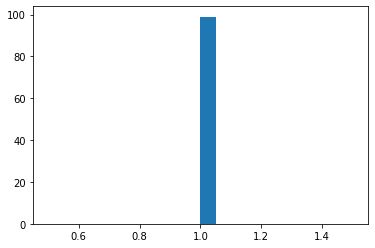

In [8]:
plt.hist(theta[:,1], bins=20)